In [1]:
import numpy as np
import astropy.wcs as wcs
from astropy.wcs import WCS
import pandas as pd
from astropy.coordinates import SkyCoord
from astropy.wcs.utils import skycoord_to_pixel
import matplotlib.pyplot as plt
from scipy.optimize import minimize

* <s>import files</s>
* <s>convert RA/DEC to pixels on detector</s>
* <s>make function to minimize (sum of diffs between points), parameters = offset, rotation, magnification</s>
* <s>move mask files to columbia computer</s>
* <s>set up masks as a class</s>
* <s>run for F1, F3, F4</s>
* make rotation + magnification around actual center 
* run for F2, QSO, QSOB

In [2]:
#mask holds information on targets, slits, and offset, rotation, magnification for each mask
class mask:
    
    def __init__(self, name, center_ra, center_dec, allow2rotate):
        
        #import relevant info from target and slit file 
        slits = pd.read_csv(name + '.csv')
        slits = slits[slits['line'] == 206]
        targets = pd.read_csv('targets_' + name + '.csv')
        slitpos = slits[['name', 'X_IMAGE', 'Y_IMAGE']]
        targetpos = targets[['Internal-count', 'RA', 'DEC']]
        targetpos = targetpos.rename(columns={"Internal-count": "name"})
        
        #combine rows matched by ID (name and Internal-count)
        self.df = pd.DataFrame.merge(slitpos, targetpos)
        
        #save RA, DEC and slit pos information matched up
        self.targetra = self.df['RA']
        self.targetdec = self.df['DEC']
        self.slitx = self.df['X_IMAGE']
        self.slity = self.df['Y_IMAGE']
        
        #create WCS header 
        self.w = wcs.WCS(naxis=2)
        self.w.wcs.crpix = [1000, 1500]
        self.w.wcs.cdelt = [ 1.08*1.027 / 3600, 1.26 *1.0063 / 3600]
        self.w.wcs.crval = [center_ra, center_dec]
        self.w.wcs.ctype = ["RA---TAN", "DEC--TAN"]
        
        #convert target RA and DEC to pixel coordinates
        coords = SkyCoord(ra = self.targetra, dec = self.targetdec, unit='deg')
        target_px = skycoord_to_pixel(coords, self.w)
        self.target_px = [target_px[1], -1*target_px[0]]
        
        #convert field center to pixel coordinates
        self.px_center = skycoord_to_pixel(SkyCoord(ra = center_ra, dec = center_dec, unit='deg'), self.w)
        
        #should it calculate rotation for this mask in get_orm_coords
        self.allow2rotate = allow2rotate 
        
            
    
    #make a first guess at the x and y offset to feed into the minimize function 
    #just uses the difference between the mean of target x,y and slit x,y
    def guess_offset(self):
        
        targetcen_x = np.nanmean(self.target_px[0])
        targetcen_y = np.nanmean(self.target_px[1])
        
        slitcen_x = np.mean(self.slitx)
        slitcen_y = np.mean(self.slity)
        
        offsetx = slitcen_x - targetcen_x
        offsety = slitcen_y - targetcen_y
        
        return offsetx, offsety 

    
        
        
        
    
    #input: original pixel coords and then offset in x and y, and magnification
    #output: translated and magnified pixel coordinates
    def get_orm_coords(self, offsetx, offsety, rotation, magnification):

        #apply optional rotation 
        if self.allow2rotate == True:
            rotation = np.deg2rad(rotation)
            target_px_delt = np.array([F2.target_px[0], F2.target_px[1]]).T - self.px_center
            cos_rot = np.cos(rotation)
            sin_rot = np.sin(rotation)
            R = np.array([[cos_rot, -1*sin_rot],
                         [sin_rot,  cos_rot]])
            target_px_r = (R @ target_px_delt.T).T + self.px_center
        else: target_px_r = np.array([self.target_px[0], self.target_px[1]]).T

        
        #apply offset 
        offset = np.array([offsetx, offsety])
        target_px_ro = np.array(target_px_r) + offset


        #apply magnification 
        target_px_ro_delt = target_px_ro - self.px_center
        target_px_rom = (target_px_ro_delt * magnification) + self.px_center

        return target_px_rom
    
    
    
    
    #inputs: args = [offset in x, offset in y, rotation, magnification], and original pixel coordinates
    #outputs: sum of squares of difference between translated/rotated/magnified coordinates and slit positions
    def distance(self, args):    
        offsetx, offsety, rotation, magnification = args

        target_px_orm = self.get_orm_coords(offsetx, offsety, rotation, magnification)

        xoff = target_px_orm[:,0] - self.slitx
        yoff = target_px_orm[:,1] - self.slity

        return np.sum(xoff**2 + yoff**2)
    
    
    
    
        
    def find_magnification(self, x0, bounds):
        x = minimize(self.distance, x0, bounds=bounds)
        
        self.offsetx = x['x'][0]
        self.offsety = x['x'][1]
        self.rotation = x['x'][2]
        self.magnification = x['x'][3]
        
        matched_target_px = self.get_orm_coords(self.offsetx, self.offsety, self.rotation, self.magnification)
        
        return matched_target_px

Magnification: 1.0122129294156523


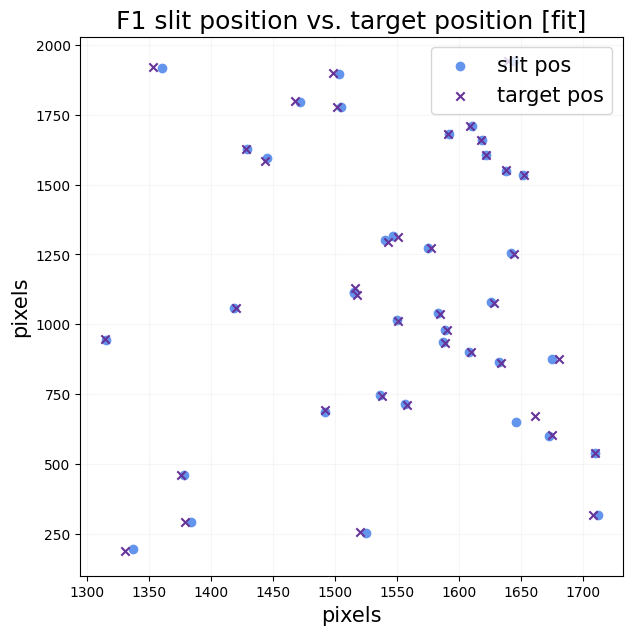

In [3]:
F1 = mask('F1', 32.19, -5.688, False)

offsetguessx, offsetguessy = F1.guess_offset()

F1_x0 = F1.get_orm_coords(offsetguessx, offsetguessy, 0, 1.0)

F1_matched = F1.find_magnification(np.array([offsetguessx, offsetguessy, 0, 1.0]), 
                                    [[offsetguessx - 50, offsetguessx + 50], [offsetguessy - 50, offsetguessy + 50], 
                                     [0, 0.1], [0.97, 1.3]])

plt.figure(figsize=(7,7))
plt.xlabel('pixels', fontsize = 15)
plt.ylabel('pixels', fontsize = 15)
plt.scatter(F1.slitx,F1.slity, label='slit pos', c='cornflowerblue')
plt.scatter(F1_matched[:,0], F1_matched[:,1], label='target pos', c='rebeccapurple', marker='x')
plt.legend(fontsize=15)
plt.grid(alpha=0.1)
plt.title('F1 slit position vs. target position [fit]', fontsize=18)


print('Magnification:', F1.magnification)

Magnification: 0.9


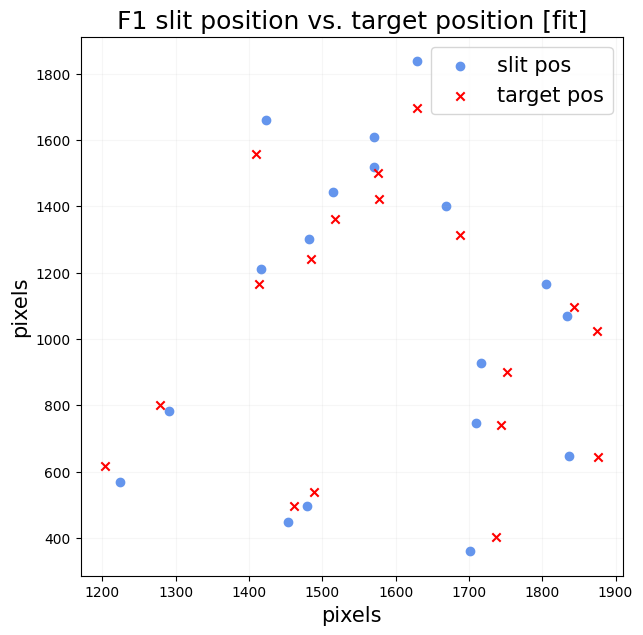

In [4]:
F2 = mask('F2', 253.0624, 34.9699, True)

offsetguessx, offsetguessy = F2.guess_offset()

F2_x0 = F2.get_orm_coords(offsetguessx - 2070, offsetguessy - 2090, 71, 1.0)

F2_matched = F2.find_magnification(np.array([offsetguessx, offsetguessy, 70, 1.0]), 
                                    [[offsetguessx - 50, offsetguessx + 50], [offsetguessy - 50, offsetguessy + 50], 
                                     [65, 75], [0.9, 1.3]])

plt.figure(figsize=(7,7))
plt.xlabel('pixels', fontsize = 15)
plt.ylabel('pixels', fontsize = 15)
plt.scatter(F2.slitx,F2.slity, label='slit pos', c='cornflowerblue')
#plt.scatter(F2_matched[:,0], F2_matched[:,1], label='target pos', c='rebeccapurple', marker='x')
plt.scatter(F2_x0[:,0], F2_x0[:,1], label='target pos', c='red', marker='x')
plt.legend(fontsize=15)
plt.grid(alpha=0.1)
plt.title('F1 slit position vs. target position [fit]', fontsize=18)


print('Magnification:', F2.magnification)

In [5]:
np.array([F2.target_px[0], F2.target_px[1]])

array([[ 2041.26204002,  1837.47007425,  1839.34296501,  1764.28040828,
         1687.43366101,  1699.19354655,  1562.75331487,  1468.61776772,
         1327.12196017,  1080.1082882 ,  1173.75410214,   881.71368549,
          900.43843129,   851.05756503,   853.05547623,  1484.63326839,
         1544.80584177,  1125.69342851],
       [ -809.69497068,  -647.67243033,  -822.53859393,  -850.37139144,
         -813.46141018,  -990.26389531,  -821.66789633,  -779.39476797,
        -1184.99305838,  -769.75820329, -1229.90156758,  -759.18665821,
        -1054.64333483, -1041.79491411, -1332.36805348, -1261.6617579 ,
        -1206.85189767, -1386.69211939]])

Magnification: 1.0178158439902498


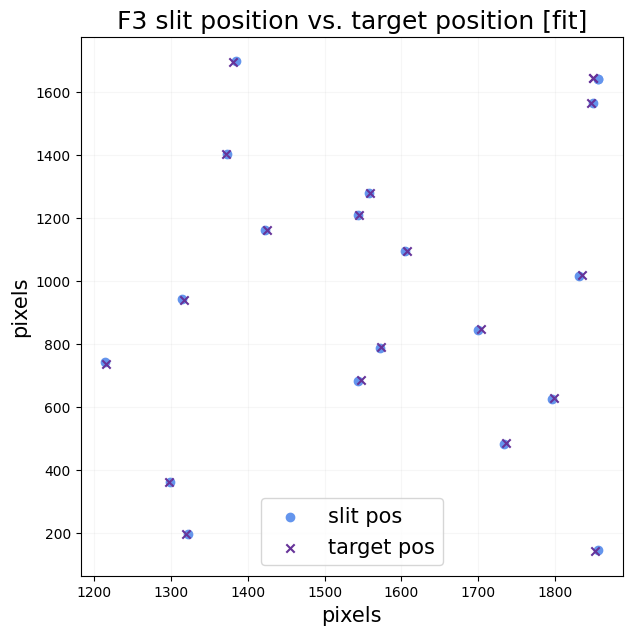

In [6]:
F3 = mask('F3', 352.3424, 0.21245, False)

offsetguessx, offsetguessy = F3.guess_offset()
F3_matched = F3.find_magnification(np.array([offsetguessx, offsetguessy, 0, 1.0]), 
                                           [[offsetguessx - 50, offsetguessx + 50], [offsetguessy - 50, offsetguessy + 50], 
                                           [0, 1], [0.97, 1.3]])
plt.figure(figsize=(7,7))
plt.xlabel('pixels', fontsize = 15)
plt.ylabel('pixels', fontsize = 15)
plt.scatter(F3.slitx, F3.slity, label='slit pos', c='cornflowerblue')
plt.scatter(F3_matched[:,0], F3_matched[:,1], label='target pos', c='rebeccapurple', marker='x')
plt.legend(fontsize=15)
plt.grid(alpha=0.1)
plt.title('F3 slit position vs. target position [fit]', fontsize=18)

print('Magnification:', F3.magnification)

Magnification: 1.0200759663477919


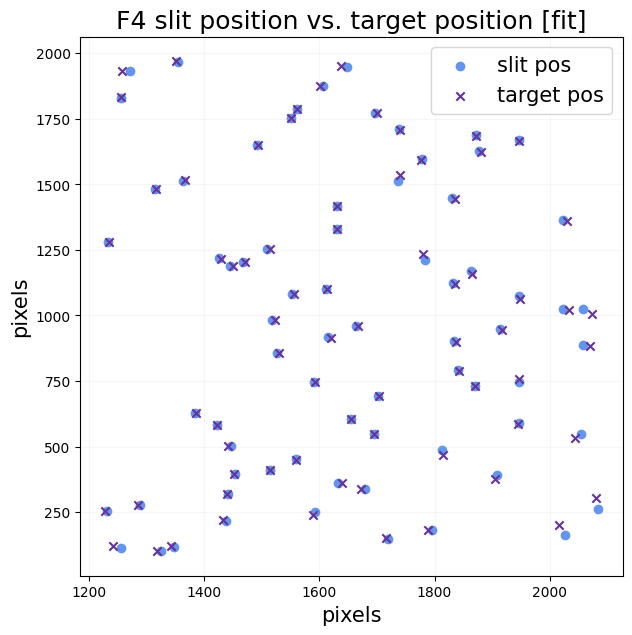

In [7]:
F4 = mask('F4', 36.9049, 0.65245, False)

offsetguessx, offsetguessy = F4.guess_offset()

F4_matched = F4.find_magnification(np.array([offsetguessx, offsetguessy, 0, 1.0]), 
                                           [[offsetguessx - 50, offsetguessx + 50], [offsetguessy - 50, offsetguessy + 50], 
                                           [0, 1], [0.97, 1.3]])
plt.figure(figsize=(7,7))
plt.xlabel('pixels', fontsize = 15)
plt.ylabel('pixels', fontsize = 15)
plt.scatter(F4.slitx, F4.slity, label='slit pos', c='cornflowerblue')
plt.scatter(F4_matched[:,0], F4_matched[:,1], label='target pos', c='rebeccapurple', marker='x')
#plt.scatter(F4_x0[:,0], F4_x0[:,1])
plt.legend(fontsize=15)
plt.grid(alpha=0.1)
plt.title('F4 slit position vs. target position [fit]', fontsize=18)

print('Magnification:', F4.magnification)

In [8]:
QSO = mask('QSO', 36.9049, 0.65245)

offsetguessx, offsetguessy = F4.guess_offset_old()

F4_matched = F4.find_magnification(np.array([offsetguessx, offsetguessy, 1.0]), 
                                           [[offsetguessx - 50, offsetguessx + 50], [offsetguessy - 50, offsetguessy + 50], 
                                           [0.97, 1.3]])
plt.figure(figsize=(7,7))
plt.xlabel('pixels', fontsize = 15)
plt.ylabel('pixels', fontsize = 15)
plt.scatter(F4.slitx, F4.slity, label='slit pos', c='forestgreen')
plt.scatter(F4_matched[:,0], F4_matched[:,1], label='target pos', c='cornflowerblue')
#plt.scatter(F4_x0[:,0], F4_x0[:,1])
plt.legend(fontsize=15)
plt.grid(alpha=0.1)
plt.title('F3 slit position vs. target position [fit]', fontsize=18)

print('Magnification:', F4.magnification)

TypeError: __init__() missing 1 required positional argument: 'allow2rotate'